**TODO**: there is a problem with the state smoothing algorithm (not the fast state smoothing algorithm)

In [1]:
using Distributions
using Gadfly

In [2]:
include("../src/ssm.jl")
include("../src/dfm.jl");

In [3]:
n = 3

μ = zeros(n)
λ = ones(n)
ϕ = 0.95
σ2v = 1.
ψ = 0.5*ones(n)
σ2w = 0.01*[1., ones(n-1)...]

dfm = MixedFreqDFM(μ, λ, ϕ, σ2v, ψ, σ2w)
ssm = get_state_space_representation(dfm)
xf1, Σxf1 = get_Kalman_filter_initialization(dfm)

T1 = 30
ΔT = 9
T = T1 + ΔT
x, y_unobs = simulate(ssm, xf1, Σxf1, T)

y = fill(NaN, T, n)
y[3:3:T1,1] = y_unobs[3:3:T1,1]
y[1:T1,2:n] = y_unobs[1:T1,2:n]

#y = y_unobs

y

39×3 Array{Float64,2}:
 NaN        -5.14387   -5.11698
 NaN        -5.87182   -5.83825
 -14.9014   -5.33503   -5.29252
 NaN        -5.65541   -5.60446
 NaN        -6.09218   -5.86498
 -18.2683   -7.61092   -7.35081
 NaN        -6.40484   -6.45   
 NaN        -7.85326   -7.76056
 -22.2661   -8.40262   -8.40322
 NaN        -7.78417   -7.78985
 NaN        -7.20686   -7.38558
 -23.651    -6.90664   -6.93576
 NaN        -6.72573   -6.65092
   ⋮                           
 NaN        -3.62567   -3.4036 
 NaN        -3.50299   -3.37412
 -11.3052   -4.47077   -4.29846
 NaN       NaN        NaN      
 NaN       NaN        NaN      
 NaN       NaN        NaN      
 NaN       NaN        NaN      
 NaN       NaN        NaN      
 NaN       NaN        NaN      
 NaN       NaN        NaN      
 NaN       NaN        NaN      
 NaN       NaN        NaN      

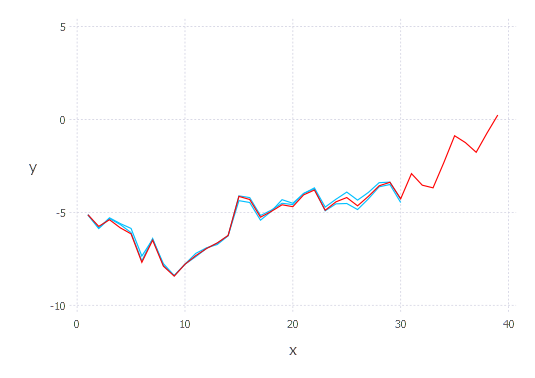

In [4]:
plot(
    layer(x=1:T, y=x[:,1], Geom.line, Theme(default_color="red")),
    #layer(x=1:T, y=y[:,1], Geom.line), # does not work for quarterly series with NaNs
    layer(x=1:T, y=y[:,2], Geom.line),
    layer(x=1:T, y=y[:,3], Geom.line)
    )

In [5]:
@time xs = fast_state_smoothing(y, ssm, xf1, Σxf1);

  1.269885 seconds (632.84 k allocations: 31.805 MiB, 1.71% gc time)


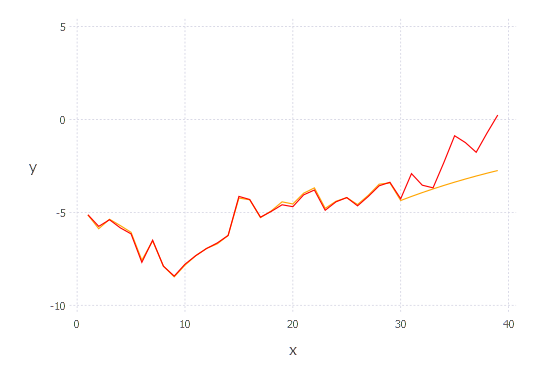

In [6]:
plot(
    layer(x=1:T, y=x[:,1], Geom.line, Theme(default_color="red")),
    layer(x=1:T, y=xs[:,1], Geom.line, Theme(default_color="orange"))
    )

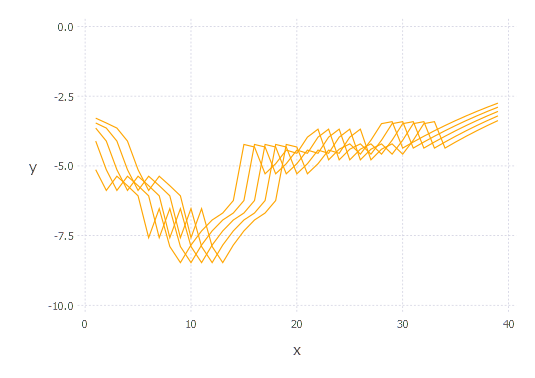

In [7]:
plot(
    [layer(x=1:T, y=xs[1:T,i], Geom.line, Theme(default_color="orange")) for i=1:5]...
    )

In [8]:
std(xs[:,6]) # why is this number not sqrt(σ2w_1) ??

0.07859724616363799

In [9]:
std(xs[:,11])

0.09934248167194601

In [10]:
std(xs[:,12])

0.0946633560399068

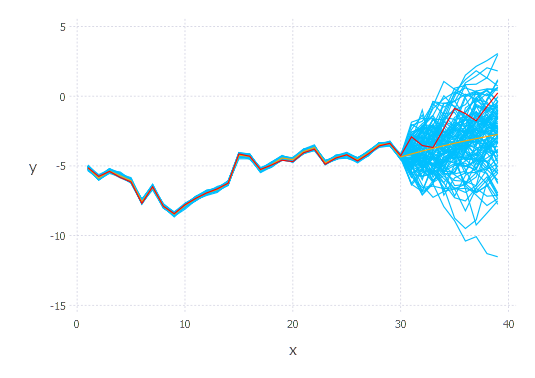

In [11]:
xs = fast_state_smoothing(y, ssm, xf1, Σxf1)

S = 100
fsims = zeros(T, S)
y2sims = zeros(T, S)
for s=1:S
    x1, y1 = simulate(ssm, xf1, Σxf1, T)
    y1[isnan.(y)] = NaN
    xs1  = fast_state_smoothing(y1, ssm, xf1, Σxf1)
    xsim = x1 - xs1 + xs
    ysim = ones(T,1)*ssm.μ' + xsim*ssm.B'
    fsims[:,s] = xsim[:,1]
    y2sims[:,s] = ysim[:,2]
end

plot(
    layer(x=1:T, y=x[:,1], Geom.line, Theme(default_color="red")),
    layer(x=1:T, y=xs[:,1], Geom.line, Theme(default_color="orange")),
    [layer(x=1:T, y=fsims[:,s], Geom.line) for s=1:S]...,
    )

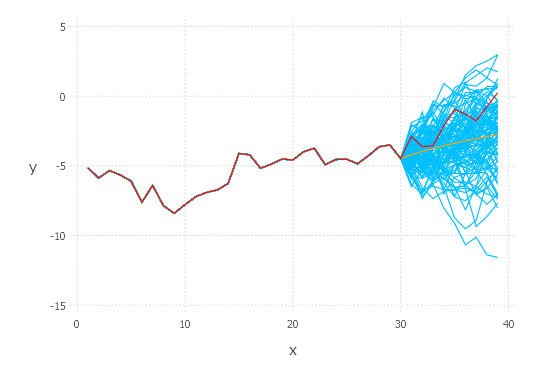

In [12]:
y_forecast = ones(T,1)*ssm.μ'+xs*ssm.B'

plot(
    layer(x=1:T, y=y_unobs[:,2], Geom.line, Theme(default_color="red")),
    layer(x=1:T, y=y_forecast[:,2], Geom.line, Theme(default_color="orange")),
    [layer(x=1:T, y=y2sims[:,s], Geom.line) for s=1:S]...,
    )

### TODO: state smoothing

- yields results different from fast state smoothing: different `xs` for rows with missing observations
- `Σxs` does not make any sense

In [13]:
xs2, Σxs2, vs2, Σvs2 = smooth_states_and_disturbances(y, ssm, xf1, Σxf1);

sum(xs - xs2 .> 1e-10)

175

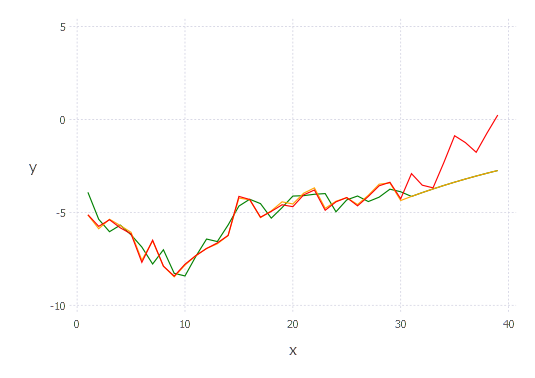

In [14]:
plot(
    layer(x=1:T, y=x[:,1], Geom.line, Theme(default_color="red")),
    layer(x=1:T, y=xs[:,1], Geom.line, Theme(default_color="orange")),
    layer(x=1:T, y=xs2[:,1], Geom.line, Theme(default_color="green")),
    )

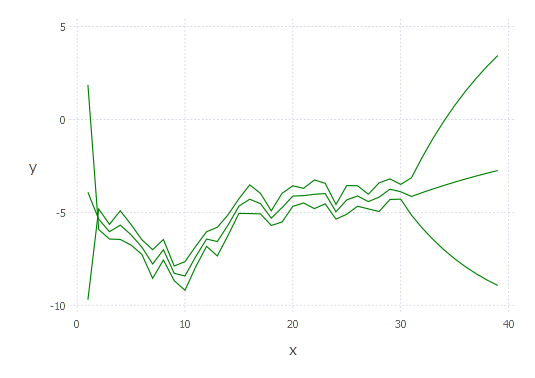

In [15]:
plot(    
    layer(x=1:T, y=xs2[:,1], Geom.line, Theme(default_color="green")),
    layer(x=1:T, y=xs2[:,1]+Σxs2[:,1,1], Geom.line, Theme(default_color="green")),
    layer(x=1:T, y=xs2[:,1]-Σxs2[:,1,1], Geom.line, Theme(default_color="green")),
    )